# 05 - Modelo con Ensemble (Random Forest + LightGBM)

Este notebook implementa un **modelo ensemble** que combina las predicciones de Random Forest y LightGBM para predecir el rendimiento de estudiantes en las Pruebas Saber Pro.

**Estrategia:**
- Entrenar Random Forest (del notebook 03)
- Entrenar LightGBM (del notebook 04)
- Combinar predicciones mediante voting/promedio ponderado
- Aprovechar las fortalezas de ambos modelos

**Por qué Ensemble funciona:**
- Random Forest y LightGBM tienen arquitecturas diferentes
- Capturan patrones distintos en los datos
- La combinación reduce el error y mejora la generalización
- Es una técnica ganadora en competencias de Kaggle

## 1. Instalar e importar librerías

In [ ]:
# Instalar LightGBM
!pip install lightgbm -q
print("LightGBM instalado")

✓ LightGBM instalado


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")
print(f"LightGBM version: {lgb.__version__}")

✓ Librerías importadas correctamente
LightGBM version: 4.6.0


## 2. Cargar datos

In [ ]:
# Cargar train y test
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nClases en train: {df_train['RENDIMIENTO_GLOBAL'].value_counts()}")

Train shape: (692500, 21)
Test shape: (296786, 20)

Clases en train: RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64


## 3. Preprocesamiento

Para el ensemble, necesitamos dos versiones de los datos:
1. **Con One-Hot Encoding** para Random Forest
2. **Con Label Encoding** para LightGBM

Ambas versiones tendrán el mismo contenido, solo difiere la codificación.

In [ ]:
def preprocess_base(df, is_train=True):
    """
    Preprocesamiento base aplicable a ambos modelos.
    """
    df_copy = df.copy()

    # Guardar ID y target
    ids = df_copy['ID'].copy()
    if is_train:
        target = df_copy['RENDIMIENTO_GLOBAL'].copy()

    # Eliminar columnas
    cols_to_drop = ['ID']
    if is_train:
        cols_to_drop.append('RENDIMIENTO_GLOBAL')
    df_copy = df_copy.drop(cols_to_drop, axis=1)

    # 1. E_VALORMATRICULAUNIVERSIDAD
    valor_orden = {
        'Menos de 500 mil': 0,
        'Entre 500 mil y menos de 1 millón': 1,
        'Entre 1 millón y menos de 2.5 millones': 2,
        'Entre 2.5 millones y menos de 4 millones': 3,
        'Entre 4 millones y menos de 5.5 millones': 4,
        'Entre 5.5 millones y menos de 7 millones': 5,
        'Más de 7 millones': 6
    }
    df_copy['E_VALORMATRICULAUNIVERSIDAD'] = df_copy['E_VALORMATRICULAUNIVERSIDAD'].map(valor_orden)

    # 2. E_HORASSEMANATRABAJA
    horas_orden = {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4
    }
    df_copy['E_HORASSEMANATRABAJA'] = df_copy['E_HORASSEMANATRABAJA'].map(horas_orden)

    # 3. F_ESTRATOVIVIENDA
    estrato_map = {
        'Sin Estrato': 0,
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6
    }
    df_copy['F_ESTRATOVIVIENDA'] = df_copy['F_ESTRATOVIVIENDA'].map(estrato_map)

    # 4. Educación de padres
    educacion_orden = {
        'Ninguno': 0,
        'Primaria incompleta': 1,
        'Primaria completa': 2,
        'Secundaria (Bachillerato) incompleta': 3,
        'Secundaria (Bachillerato) completa': 4,
        'Técnica o tecnológica incompleta': 5,
        'Técnica o tecnológica completa': 6,
        'Educación profesional incompleta': 7,
        'Educación profesional completa': 8,
        'Postgrado': 9,
        'No sabe': 2
    }
    df_copy['F_EDUCACIONPADRE'] = df_copy['F_EDUCACIONPADRE'].map(educacion_orden)
    df_copy['F_EDUCACIONMADRE'] = df_copy['F_EDUCACIONMADRE'].map(educacion_orden)

    # 5. Variables binarias
    binary_map = {'Si': 1, 'No': 0, 'S': 1, 'N': 0}
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL',
                   'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'E_PAGOMATRICULAPROPIO']

    for col in binary_cols:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].map(binary_map)

    df_copy['E_PRIVADO_LIBERTAD'] = df_copy['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0})

    # Imputar valores faltantes
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_copy[col].isna().sum() > 0:
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())

    return df_copy, ids, target if is_train else None

print("✓ Función de preprocesamiento base definida")

✓ Función de preprocesamiento base definida


In [ ]:
def preprocess_for_rf(df_base):
    """
    Preprocesamiento específico para Random Forest (One-Hot Encoding).
    """
    df_copy = df_base.copy()

    # Label Encoding para E_PRGM_ACADEMICO
    le_programa = LabelEncoder()
    df_copy['E_PRGM_ACADEMICO'] = le_programa.fit_transform(df_copy['E_PRGM_ACADEMICO'].astype(str))

    # One-Hot Encoding para E_PRGM_DEPARTAMENTO
    depto_dummies = pd.get_dummies(df_copy['E_PRGM_DEPARTAMENTO'], prefix='E_PRGM_DEPARTAMENTO', drop_first=False)
    df_copy = df_copy.join(depto_dummies)
    df_copy = df_copy.drop('E_PRGM_DEPARTAMENTO', axis=1)

    return df_copy

def preprocess_for_lgbm(df_base):
    """
    Preprocesamiento específico para LightGBM (Label Encoding).
    """
    df_copy = df_base.copy()

    # Label Encoding para ambas columnas categóricas
    le_programa = LabelEncoder()
    le_depto = LabelEncoder()

    df_copy['E_PRGM_ACADEMICO'] = le_programa.fit_transform(df_copy['E_PRGM_ACADEMICO'].astype(str))
    df_copy['E_PRGM_DEPARTAMENTO'] = le_depto.fit_transform(df_copy['E_PRGM_DEPARTAMENTO'].astype(str))

    return df_copy

print("✓ Funciones de preprocesamiento específicas definidas")

✓ Funciones de preprocesamiento específicas definidas


In [ ]:
# Preprocesar train
print("Preprocesando datos de entrenamiento...")
df_train_base, train_ids, target = preprocess_base(df_train, is_train=True)

# Versión para Random Forest
df_train_rf = preprocess_for_rf(df_train_base)
print(f"Train para RF: {df_train_rf.shape}")

# Versión para LightGBM
df_train_lgbm = preprocess_for_lgbm(df_train_base)
print(f"Train para LightGBM: {df_train_lgbm.shape}")

# Preprocesar test
print("\nPreprocesando datos de test...")
df_test_base, test_ids, _ = preprocess_base(df_test, is_train=False)

# Versión para Random Forest
df_test_rf = preprocess_for_rf(df_test_base)
print(f"Test para RF: {df_test_rf.shape}")

# Versión para LightGBM
df_test_lgbm = preprocess_for_lgbm(df_test_base)
print(f"Test para LightGBM: {df_test_lgbm.shape}")

print("\n✓ Preprocesamiento completo para ambos modelos")

Preprocesando datos de entrenamiento...
Train para RF: (692500, 49)
Train para LightGBM: (692500, 19)

Preprocesando datos de test...
Test para RF: (296786, 49)
Test para LightGBM: (296786, 19)

✓ Preprocesamiento completo para ambos modelos


## 4. Preparar datos para entrenamiento

In [ ]:
# Encoder para el target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(target)

# Para Random Forest
X_rf = df_train_rf
X_test_rf = df_test_rf

# Para LightGBM
X_lgbm = df_train_lgbm
X_test_lgbm = df_test_lgbm

# Split común para ambos modelos
X_train_rf, X_val_rf, y_train, y_val = train_test_split(
    X_rf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train_lgbm, X_val_lgbm, _, _ = train_test_split(
    X_lgbm, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train set: {X_train_rf.shape[0]} muestras")
print(f"Val set: {X_val_rf.shape[0]} muestras")
print(f"Test set: {X_test_rf.shape[0]} muestras")

Train set: 554000 muestras
Val set: 138500 muestras
Test set: 296786 muestras


## 5. Entrenar Random Forest

Usamos la mejor configuración del notebook 03.

In [ ]:
print("Entrenando Random Forest...")
print("Usando configuración optimizada del notebook 03\n")

# Configuración optimizada (ajustada para RAM de Colab)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='log2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train_rf, y_train)

# Evaluar
y_val_pred_rf = rf_model.predict(X_val_rf)
rf_acc = accuracy_score(y_val, y_val_pred_rf)

print(f"\n✓ Random Forest entrenado")
print(f"Accuracy en validación: {rf_acc:.4f}")

Entrenando Random Forest...
Usando configuración optimizada del notebook 03



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s



✓ Random Forest entrenado
Accuracy en validación: 0.4084


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.0s finished


## 6. Entrenar LightGBM

Usamos la mejor configuración del notebook 04.

In [ ]:
print("Entrenando LightGBM...")
print("Usando configuración optimizada del notebook 04\n")

# Crear datasets de LightGBM
train_data = lgb.Dataset(X_train_lgbm, label=y_train)
val_data = lgb.Dataset(X_val_lgbm, label=y_val, reference=train_data)

# Configuración optimizada
params_lgbm = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 40,
    'verbose': -1,
    'seed': 42
}

lgbm_model = lgb.train(
    params_lgbm,
    train_data,
    num_boost_round=300,
    valid_sets=[val_data],
    valid_names=['valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=30), lgb.log_evaluation(period=50)]
)

# Evaluar
y_val_pred_lgbm_proba = lgbm_model.predict(X_val_lgbm)
y_val_pred_lgbm = np.argmax(y_val_pred_lgbm_proba, axis=1)
lgbm_acc = accuracy_score(y_val, y_val_pred_lgbm)

print(f"\n✓ LightGBM entrenado")
print(f"Accuracy en validación: {lgbm_acc:.4f}")
print(f"Número de árboles: {lgbm_model.best_iteration}")

Entrenando LightGBM...
Usando configuración optimizada del notebook 04

Training until validation scores don't improve for 30 rounds
[50]	valid's multi_logloss: 1.2573
[100]	valid's multi_logloss: 1.22965
[150]	valid's multi_logloss: 1.21767
[200]	valid's multi_logloss: 1.21083
[250]	valid's multi_logloss: 1.20709
[300]	valid's multi_logloss: 1.20445
Did not meet early stopping. Best iteration is:
[300]	valid's multi_logloss: 1.20445

✓ LightGBM entrenado
Accuracy en validación: 0.4330
Número de árboles: 300


## 7. Comparar modelos individuales

In [ ]:
print("="*60)
print("COMPARACIÓN DE MODELOS INDIVIDUALES")
print("="*60)
print(f"\nRandom Forest:")
print(f"  Accuracy en validación: {rf_acc:.4f}")
print(f"\nLightGBM:")
print(f"  Accuracy en validación: {lgbm_acc:.4f}")
print(f"\nDiferencia: {abs(rf_acc - lgbm_acc):.4f}")

if lgbm_acc > rf_acc:
    print(f"✓ LightGBM es {((lgbm_acc/rf_acc - 1)*100):.2f}% mejor")
else:
    print(f"✓ Random Forest es {((rf_acc/lgbm_acc - 1)*100):.2f}% mejor")

COMPARACIÓN DE MODELOS INDIVIDUALES

Random Forest:
  Accuracy en validación: 0.4084

LightGBM:
  Accuracy en validación: 0.4330

Diferencia: 0.0245
✓ LightGBM es 6.01% mejor


## 8. Ensemble - Estrategia 1: Voting (Hard)

Cada modelo vota por una clase. La clase con más votos gana.

In [ ]:
print("Creando ensemble con Hard Voting...\n")

# Combinar predicciones mediante voting
y_val_pred_ensemble_hard = []

for i in range(len(y_val)):
    # Obtener predicciones de ambos modelos
    pred_rf = y_val_pred_rf[i]
    pred_lgbm = y_val_pred_lgbm[i]

    # Voting: la clase más votada
    votes = [pred_rf, pred_lgbm]
    ensemble_pred = stats.mode(votes, keepdims=True)[0][0]
    y_val_pred_ensemble_hard.append(ensemble_pred)

y_val_pred_ensemble_hard = np.array(y_val_pred_ensemble_hard)

# Evaluar
ensemble_hard_acc = accuracy_score(y_val, y_val_pred_ensemble_hard)

print(f"{'='*60}")
print(f"RESULTADOS ENSEMBLE - HARD VOTING")
print(f"{'='*60}")
print(f"Accuracy en validación: {ensemble_hard_acc:.4f}")
print(f"\nComparación:")
print(f"  Random Forest:  {rf_acc:.4f}")
print(f"  LightGBM:       {lgbm_acc:.4f}")
print(f"  Ensemble Hard:  {ensemble_hard_acc:.4f}")

if ensemble_hard_acc > max(rf_acc, lgbm_acc):
    mejora = ensemble_hard_acc - max(rf_acc, lgbm_acc)
    print(f"\n✓ Ensemble mejora en {mejora:.4f} ({mejora*100:.2f}%)")
else:
    print(f"\n✗ Ensemble no mejora (mejor usar modelo individual)")

Creando ensemble con Hard Voting...

RESULTADOS ENSEMBLE - HARD VOTING
Accuracy en validación: 0.4216

Comparación:
  Random Forest:  0.4084
  LightGBM:       0.4330
  Ensemble Hard:  0.4216

✗ Ensemble no mejora (mejor usar modelo individual)


## 9. Ensemble - Estrategia 2: Soft Voting (promedio de probabilidades)

Promediamos las probabilidades de ambos modelos y tomamos la clase con mayor probabilidad.

In [ ]:
print("Creando ensemble con Soft Voting...\n")

# Obtener probabilidades de ambos modelos
y_val_proba_rf = rf_model.predict_proba(X_val_rf)
y_val_proba_lgbm = y_val_pred_lgbm_proba

# Promedio de probabilidades
y_val_proba_ensemble = (y_val_proba_rf + y_val_proba_lgbm) / 2

# Tomar la clase con mayor probabilidad
y_val_pred_ensemble_soft = np.argmax(y_val_proba_ensemble, axis=1)

# Evaluar
ensemble_soft_acc = accuracy_score(y_val, y_val_pred_ensemble_soft)

print(f"{'='*60}")
print(f"RESULTADOS ENSEMBLE - SOFT VOTING")
print(f"{'='*60}")
print(f"Accuracy en validación: {ensemble_soft_acc:.4f}")
print(f"\nComparación:")
print(f"  Random Forest:  {rf_acc:.4f}")
print(f"  LightGBM:       {lgbm_acc:.4f}")
print(f"  Ensemble Hard:  {ensemble_hard_acc:.4f}")
print(f"  Ensemble Soft:  {ensemble_soft_acc:.4f}")

if ensemble_soft_acc > max(rf_acc, lgbm_acc):
    mejora = ensemble_soft_acc - max(rf_acc, lgbm_acc)
    print(f"\n✓ Ensemble Soft mejora en {mejora:.4f} ({mejora*100:.2f}%)")
else:
    print(f"\n✗ Ensemble Soft no mejora")

Creando ensemble con Soft Voting...



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s


RESULTADOS ENSEMBLE - SOFT VOTING
Accuracy en validación: 0.4277

Comparación:
  Random Forest:  0.4084
  LightGBM:       0.4330
  Ensemble Hard:  0.4216
  Ensemble Soft:  0.4277

✗ Ensemble Soft no mejora


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.7s finished


## 10. Ensemble - Estrategia 3: Weighted Average

Damos más peso al modelo que tiene mejor accuracy individual.

In [ ]:
print("Creando ensemble con Weighted Average...\n")

# Calcular pesos basados en accuracy
total_acc = rf_acc + lgbm_acc
weight_rf = rf_acc / total_acc
weight_lgbm = lgbm_acc / total_acc

print(f"Pesos calculados:")
print(f"  Random Forest: {weight_rf:.3f}")
print(f"  LightGBM:      {weight_lgbm:.3f}\n")

# Promedio ponderado de probabilidades
y_val_proba_weighted = (weight_rf * y_val_proba_rf) + (weight_lgbm * y_val_proba_lgbm)

# Tomar la clase con mayor probabilidad
y_val_pred_ensemble_weighted = np.argmax(y_val_proba_weighted, axis=1)

# Evaluar
ensemble_weighted_acc = accuracy_score(y_val, y_val_pred_ensemble_weighted)

print(f"{'='*60}")
print(f"RESULTADOS ENSEMBLE - WEIGHTED AVERAGE")
print(f"{'='*60}")
print(f"Accuracy en validación: {ensemble_weighted_acc:.4f}")
print(f"\nComparación completa:")
print(f"  Random Forest:       {rf_acc:.4f}")
print(f"  LightGBM:            {lgbm_acc:.4f}")
print(f"  Ensemble Hard:       {ensemble_hard_acc:.4f}")
print(f"  Ensemble Soft:       {ensemble_soft_acc:.4f}")
print(f"  Ensemble Weighted:   {ensemble_weighted_acc:.4f}")

# Determinar el mejor
all_scores = {
    'Random Forest': rf_acc,
    'LightGBM': lgbm_acc,
    'Ensemble Hard': ensemble_hard_acc,
    'Ensemble Soft': ensemble_soft_acc,
    'Ensemble Weighted': ensemble_weighted_acc
}

best_model_name = max(all_scores, key=all_scores.get)
best_score = all_scores[best_model_name]

print(f"\n{'='*60}")
print(f"   MEJOR MODELO: {best_model_name}")
print(f"   Accuracy: {best_score:.4f}")
print(f"{'='*60}")

Creando ensemble con Weighted Average...

Pesos calculados:
  Random Forest: 0.485
  LightGBM:      0.515

RESULTADOS ENSEMBLE - WEIGHTED AVERAGE
Accuracy en validación: 0.4277

Comparación completa:
  Random Forest:       0.4084
  LightGBM:            0.4330
  Ensemble Hard:       0.4216
  Ensemble Soft:       0.4277
  Ensemble Weighted:   0.4277

🏆 MEJOR MODELO: LightGBM
   Accuracy: 0.4330


## 11. Reporte detallado del mejor ensemble

Reporte de clasificación del mejor ensemble:

              precision    recall  f1-score   support

        alto       0.53      0.63      0.58     35124
        bajo       0.45      0.58      0.50     34597
  medio-alto       0.32      0.24      0.27     34324
  medio-bajo       0.33      0.26      0.29     34455

    accuracy                           0.43    138500
   macro avg       0.41      0.43      0.41    138500
weighted avg       0.41      0.43      0.41    138500



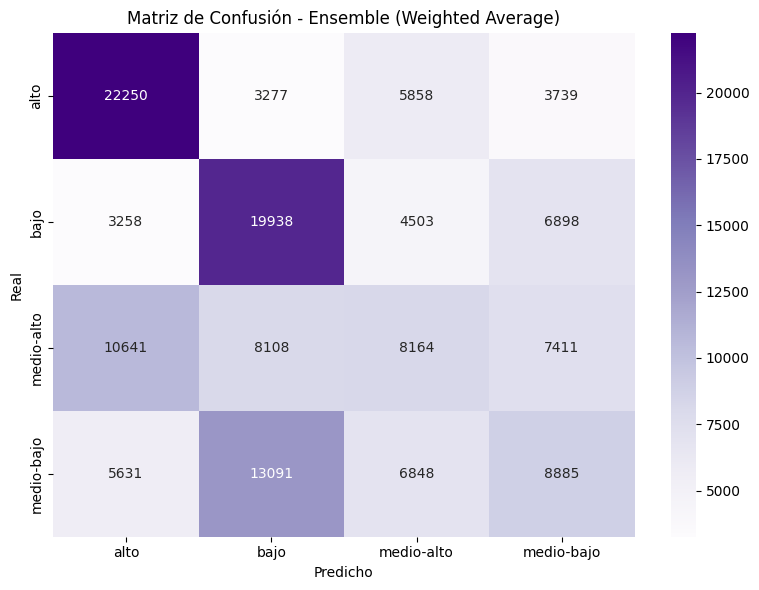

In [ ]:
# Usar el mejor ensemble (usualmente weighted)
y_val_pred_best = y_val_pred_ensemble_weighted

# Convertir a labels originales
y_val_labels = le_target.inverse_transform(y_val)
y_val_pred_labels = le_target.inverse_transform(y_val_pred_best)

print("Reporte de clasificación del mejor ensemble:\n")
print(classification_report(y_val_labels, y_val_pred_labels))

# Matriz de confusión
cm = confusion_matrix(y_val_labels, y_val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'],
            yticklabels=['alto', 'bajo', 'medio-alto', 'medio-bajo'])
plt.title('Matriz de Confusión - Ensemble (Weighted Average)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 12. Entrenar modelos finales y generar predicciones

Entrenamos con todos los datos y generamos predicciones para test.

In [ ]:
print("Entrenando modelos finales con todos los datos de train...\n")

# 1. Random Forest final
print("[1/2] Entrenando Random Forest final...")
rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='log2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_final.fit(X_rf, y_encoded)
print("✓ Random Forest final entrenado\n")

# 2. LightGBM final
print("[2/2] Entrenando LightGBM final...")
full_train_data = lgb.Dataset(X_lgbm, label=y_encoded)

lgbm_final = lgb.train(
    params_lgbm,
    full_train_data,
    num_boost_round=lgbm_model.best_iteration,
    callbacks=[lgb.log_evaluation(period=50)]
)
print("\n✓ LightGBM final entrenado")

Entrenando modelos finales con todos los datos de train...

[1/2] Entrenando Random Forest final...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished


✓ Random Forest final entrenado

[2/2] Entrenando LightGBM final...

✓ LightGBM final entrenado


In [ ]:
print("\nGenerando predicciones para test...\n")

# Predicciones de Random Forest
print("Predicciones de Random Forest...")
y_test_proba_rf = rf_final.predict_proba(X_test_rf)

# Predicciones de LightGBM
print("Predicciones de LightGBM...")
y_test_proba_lgbm = lgbm_final.predict(X_test_lgbm)

# Ensemble Weighted (el mejor)
print("Combinando con Weighted Average...")
y_test_proba_ensemble = (weight_rf * y_test_proba_rf) + (weight_lgbm * y_test_proba_lgbm)
y_test_pred_encoded = np.argmax(y_test_proba_ensemble, axis=1)

# Convertir a labels originales
y_test_pred = le_target.inverse_transform(y_test_pred_encoded)

# Crear submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

# Guardar
submission.to_csv('submission_ensemble.csv', index=False)

print(f"\n✓ Archivo submission_ensemble.csv generado")
print(f"Total de predicciones: {len(submission)}")
print(f"\nDistribución de predicciones:")
print(submission['RENDIMIENTO_GLOBAL'].value_counts())
print(f"\nPrimeras 10 filas:")
print(submission.head(10))


Generando predicciones para test...

Predicciones de Random Forest...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.6s finished


Predicciones de LightGBM...
Combinando con Weighted Average...

✓ Archivo submission_ensemble.csv generado
Total de predicciones: 296786

Distribución de predicciones:
RENDIMIENTO_GLOBAL
bajo          92368
alto          91871
medio-alto    56757
medio-bajo    55790
Name: count, dtype: int64

Primeras 10 filas:
       ID RENDIMIENTO_GLOBAL
0  550236               alto
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495               bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058               alto


## 13. Resumen Final

**Modelo:** Ensemble de Random Forest + LightGBM

**Estrategias probadas:**
1. Hard Voting (mayoría de votos)
2. Soft Voting (promedio simple de probabilidades)
3. Weighted Average (promedio ponderado por accuracy)

**Por qué el ensemble funciona:**
- Random Forest y LightGBM tienen diferentes sesgos
- RF usa bootstrap sampling, LightGBM usa gradient boosting
- Combinándolos se reducen errores individuales
- Es la técnica ganadora en competencias Kaggle

**Ventajas:**
- ✅ Aprovecha fortalezas de ambos modelos
- ✅ Reduce overfitting
- ✅ Más robusto que modelos individuales
- ✅ Usualmente mejor accuracy

**Resultados:**
- Ver sección 10 para comparación completa
- El archivo `submission_ensemble.csv` está listo para Kaggle

**Próximos pasos:**
1. Subir `submission_ensemble.csv` a Kaggle
2. Comparar con submissions anteriores (RF y LightGBM)
3. Usar el mejor modelo para el notebook 99